In [1]:
using Plots

In [56]:
n = 2
p = 1
m = 1.
l = 1.
g = 9.8
mu = 0.01

0.01

In [57]:
function f(x,u)
    return [x[2]; (g/l*sin(x[1]) - mu/m/(l^2)*x[2] + 1/m/(l^2)*u)];
end

function fx(x,dt)
    [(1 + g*cos(x[1])*(dt^2)/(2*l)) (dt - mu*(dt^2)/(2*m*l^2)); (g*cos(x[1] + x[2]*dt/2)*dt/l - mu*g*cos(x[1])*(dt^2)/(2*m*l^3)) (1 + g*cos(x[1] + x[2]*dt/2)*(dt^2)/(2*l) - mu*dt/(m*l^2) + (mu^2)*(dt^2)/(2*(m^2)*l^4))]
end

function fu(x,dt)
    [(dt^2)/(2*m*l^2); (-mu*(dt^2)/(2*(m^2)*l^4) + dt/(m*l^2))];
end
 
function dynamics(x,u,dt)
    return x + f(x + f(x,u)*dt/2,u)*dt
end

dynamics (generic function with 1 method)

In [58]:
#initial conditions
x0 = [0.; 0.]

#goal
xf = [pi; 0.] # (ie, swing up)

#costs
Q = 1e-5*eye(n)
Qf = 25.*eye(n)
R = 1e-5*eye(p)

e_dJ = 1e-6

1.0e-6

In [59]:
#simulation
dt = 0.1
tf = 1.
N = convert(Int64,floor(tf/dt))
t = linspace(0,tf,N)
iterations = 100

#initialization
u = zeros(p,N-1)
x = zeros(n,N)
x_prev = zeros(n,N)
x[:,1] = x0
N

10

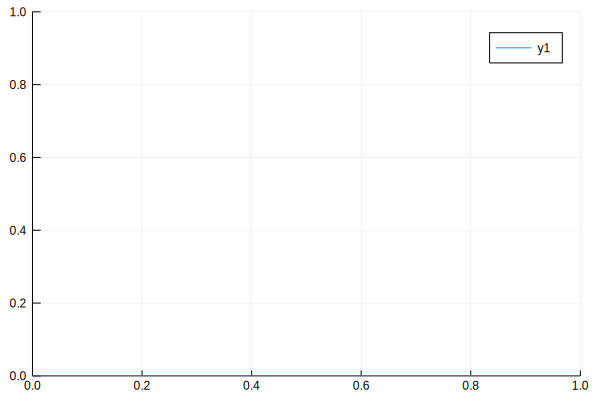

In [61]:
#first roll-out
for k = 2:N
    x[:,k] = dynamics(x[:,k-1],u[:,k-1],dt)
end

plot(linspace(0,tf,N),x[1,:])

In [62]:
#original cost
J = 0.
for k = 1:N-1
    J = J + (x[:,k] - xf)'*Q*(x[:,k] - xf) + u[:,k]'*R*u[:,k];
end
J = 0.5*(J + (x[:,N] - xf)'*Qf*(x[:,N] - xf))
print("Original Cost: $J")

Original Cost: 123.37049914581503

In [68]:
function rollout(x0,U,dt,tf,dynamics)
    N = convert(Int64,floor(tf/dt))
    X = zeros(size(x0,1),N)
    X[:,1] = x0
    for k = 1:N-1
      X[:,k+1] = dynamics(X[:,k],U[:,k],dt)
    end
    return X
end

function cost(X,U,Q,R,Qf,xf)
    N = size(X,2)
    J = 0.
    for k = 1:N-1
      J += 0.5*(X[:,k] - xf)'*Q*(X[:,k] - xf) + 0.5*U[:,k]'*R*U[:,k]
    end
    J += 0.5*(X[:,N] - xf)'*Qf*(X[:,N] - xf)
    return J
end

X = rollout(x0,u,dt,tf,dynamics)
plot(linspace(0,tf,N),x[1,:])
J = cost(X,u,Q,R,Qf,xf)
print("Original Cost: $J")

Original Cost: 123.37049914581503

In [8]:
print("Original Cost: $J")
for i = 1:iterations
    
    S = zeros(n,n,N)
    S[:,:,N] = Qf
    s = zeros(n,N)
    s[:,N] = Qf*(x[:,N] - xf)
    K = zeros(p,n,N)
    lk = zeros(p,N)
    C1 = zeros(1,n,N)
    C2 = zeros(1,m,N)
    C3 = zeros(n,n,N)
    C4 = zeros(m,m,N)
    C5 = zeros(m,n,N)
    
    mu_reg = 0.
    k = N-1
    while k >= 1
        q = Q*(x[:,k] - xf)
        r = R*(u[:,k])
        A = fx(x[:,k],dt)
        B = fu(x[:,k],dt);
        C1[:,:,k] = q' + s[:,k+1]'*A 
        C2[:,:,k] = r' + s[:,k+1]'*B
        C3[:,:,k] = Q + A'*S[:,:,k+1]*A
        C4[:,:,k] = R + B'*(S[:,:,k+1] + mu_reg*eye(n))*B
        C5[:,:,k] = B'*(S[:,:,k+1] + mu_reg*eye(n))*A
        
        #regularization
        eig_val, eig_vec = eig(C4[:,:,k])
        if any(x->x<0,eig_val)
            mu_reg = mu_reg + 1;
            k = N-1;
            print("Regularize")
        end
        
        K[:,:,k] = inv(C4[:,:,k])*C5[:,:,k]
        lk[:,k] = inv(C4[:,:,k])*C2[:,:,k]'
        
        s[:,k] = C1[:,:,k] - C2[:,:,k]*K[:,:,k] + lk[:,k]'*C4[:,:,k]*K[:,:,k] - lk[:,k]*C5[:,:,k]
        S[:,:,k] = C3[:,:,k] + K[:,:,k]'*C4[:,:,k]*K[:,:,k] - K[:,:,k]'*C5[:,:,k] - C5[:,:,k]'*K[:,:,k]
        
        k = k - 1;
    end
    #update control, roll out new policy, calculate new cost
    x_prev = copy(x)
    J_prev = copy(J)
    u_ = zeros(p,N-1)
    J = Inf
    alpha = 1
    iter = 0
    
    while J > J_prev #|| iter == 0
        x = zeros(n,N)
        x[:,1] = x0
        for k = 2:N
            u_[:,k-1] = u[:,k-1] - K[:,:,k-1]*(x[:,k-1] - x_prev[:,k-1]) + alpha*(-lk[:,k-1])
            x[:,k] = dynamics(x[:,k-1],u_[:,k-1],dt);
        end
        
        J = 0;
        for k = 1:N-1
            J = J + (x[:,k] - xf)'*Q*(x[:,k] - xf) + u_[:,k]'*R*u_[:,k];
        end
        J = 0.5*(J + (x[:,N] - xf)'*Qf*(x[:,N] - xf))
        
        alpha = alpha/2;
        iter = iter + 1;
    end
    println("New cost: $J")
    u = copy(u_);
    
    if abs(J - J_prev) < e_dJ
        print("eps criteria met at iteration:$i")
        break
    end
end
print("complete")

Original Cost: 123.37049914581503[10.2988 10.5086][111.417 15.2726][61.0256 11.3485][40.9601 9.22741][31.1433 7.94824][25.7325 7.12822][22.5265 6.58447][20.5415 6.2177][19.2806 5.96874]New cost: 92.2413701820951
[-9.12452 9.53929][88.8992 14.5875][42.5609 10.4125][25.8558 8.10941][19.62 6.78217][17.723 6.06833][17.5038 5.74461][17.6836 5.63395][17.7519 5.60561]New cost: 0.010495638659399134
[-9.29999 9.53056][87.834 14.5598][41.4145 10.3569][25.0632 8.04124][19.3097 6.72784][17.7381 6.04469][17.642 5.74837][17.8251 5.65097][17.8625 5.62421]New cost: 0.010415333341927001
[-9.30009 9.53056][87.8107 14.5593][41.3602 10.3548][24.985 8.03646][19.2287 6.72048][17.671 6.0362][17.595 5.74059][17.7963 5.64508][17.8464 5.62036]New cost: 0.010415324294714909
eps criteria met at iteration:4complete

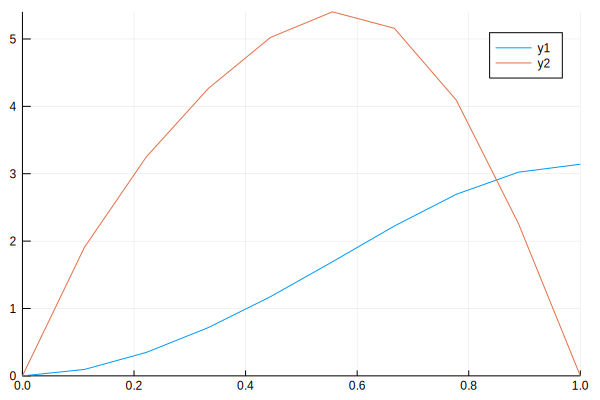

In [9]:
plot(linspace(0,tf,N),x[1,:])
plot!(linspace(0,tf,N),x[2,:])

In [100]:
using ForwardDiff
h(x::Vector) = sin(x)sum(sin,x)# + prod(tan,x)*sum(sqrt,x)
H = x -> ForwardDiff.Jacobian(h,x)
H([1.;1.])


LoadError: [91mUndefVarError: Jacobian not defined[39m

In [94]:
sum(sin,[1;2])

1.7507684116335782

In [102]:
p(x) = sin(x)
P = x -> ForwardDiff.derivative(p,x)
print(p(0),P(0))

LoadError: [91mcannot define function p; it already has a value[39m